In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import gensim as gs
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
warnings.filterwarnings('ignore')
import fasttext

In [12]:
true_pairs = pd.read_csv('create_true_false_pairs/true_pairs_by_cosine_070.csv', delimiter=',')
false_pairs = pd.read_csv('create_true_false_pairs/false_pairs_by_ids.csv', delimiter=',')
#false_pairs = false_pairs.head((len(true_pairs))*1)

In [8]:
df_concat = pd.concat([true_pairs,false_pairs])

In [13]:
len(false_pairs)

1020526

In [20]:
train_dataset, validation_dataset = train_test_split(df_concat, test_size=0.10, random_state=42)

In [5]:
# embedding_model = gs.models.FastText.load_fasttext_format('pre_trained_models/cc.en.300.bin')
embedding_model = gs.models.FastText.load('train_embedding_models/fasttext_embedding_50d')

In [6]:
MAX_PAD = 31

def sequence_padding(X_DIM, value):
    
    value_padding = np.pad(value, ((0,MAX_PAD - X_DIM),(0,0)), 'constant')
    
    return value_padding

In [7]:
def create_embedding(value):

    value = tknzr.tokenize(str(value))
    
    if len(value) < MAX_PAD:
        
        embedding = embedding_model.wv[value]
        
        padding_embedding = sequence_padding(embedding.shape[0],embedding)
        
        return padding_embedding
        
    else:
        
        embedding = embedding_model.wv[value[0:MAX_PAD]]
        
        return embedding

In [ ]:
train_article_title = []
train_table_title = []
train_label = []

for i,row in tqdm(train_dataset.iterrows()):
    
    train_article_title.append(create_embedding(row['article_page_title']))
    train_table_title.append(create_embedding(row['table_page_title']))
    train_label.append(row['label'])

In [ ]:
train_article_title = np.array(train_article_title)
train_table_title = np.array(train_table_title)
train_label = np.array(train_label)

In [ ]:
train_article_title.shape

In [21]:
validation_article_title = []
validation_table_title = []
validation_label = []

for i, row in tqdm(validation_dataset.iterrows()):
    
    validation_article_title.append(create_embedding(row['article_page_title']))
    validation_table_title.append(create_embedding(row['table_page_title']))  
    validation_label.append(row['label'])

109169it [01:29, 1221.71it/s]


In [22]:
validation_article_title = np.array(validation_article_title)
validation_table_title = np.array(validation_table_title)
validation_label = np.array(validation_label)

In [23]:
validation_article_title.shape

(109169, 31, 50)

In [ ]:
def coattention_method(query, document):
    
    transpose_document = tf.transpose(document,perm=[0, 2, 1])
    
    affinity = tf.matmul(query,transpose_document)

#     transpose_affinity = tf.transpose(affinity, perm=[0, 2, 1])
    
#     row_normalized = tf.nn.softmax(affinity, axis=1)
    
#     column_normalized = tf.nn.softmax(transpose_affinity, axis=1)
    
#     context_vector = tf.matmul(row_normalized,document)
    
#     concatenate_context_query = tf.concat([context_vector,query],axis=-1)
     
#     context_document = tf.matmul(column_normalized,concatenate_context_query)
    
#     co_attention = tf.concat([document,context_document],axis=-1)
    
    return affinity

In [ ]:
def attention_model():
    
    article_title = tf.keras.Input(shape=(31,50), dtype='float32')
    table_title = tf.keras.Input(shape=(31,50), dtype='float32')
    
    encodding_article_title = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True))(article_title)
    encodding_table_title = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True))(table_title)
    
    attention_title_title = coattention_method(encodding_article_title,encodding_table_title)
    
    encodding_attention = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True))(attention_title_title)
    
    learned_vector = tf.keras.layers.Flatten()(encodding_attention)
   
    dense1 = tf.keras.layers.Dense(64, activation='relu')(learned_vector)
    dropout1 = tf.keras.layers.Dropout(0.5, name="dropout1")(dense1)
    prediction = tf.keras.layers.Dense(1,activation='sigmoid')(dropout1)
    
    model = tf.keras.Model(inputs=[article_title,table_title],outputs=prediction)
    
    return model

In [ ]:
model = attention_model()

In [ ]:
model.compile(loss="binary_crossentropy",optimizer="adam", metrics=['accuracy'])

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('affinity_model_train_ids.h5', monitor='val_acc',verbose=1, save_the_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit([train_article_title, train_table_title], train_label, 
          epochs=10, 
          batch_size=32, 
          validation_data=([validation_article_title, validation_table_title], validation_label),
          callbacks=callbacks_list)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
model = tf.keras.models.load_model('affinity_model_train_cossine.h5')

In [28]:
y_prob = model.predict([validation_article_title,validation_table_title])
y_predict = (y_prob > 0.5).astype(np.int)
accuracy_score(validation_label, y_predict)

0.9982595791845671

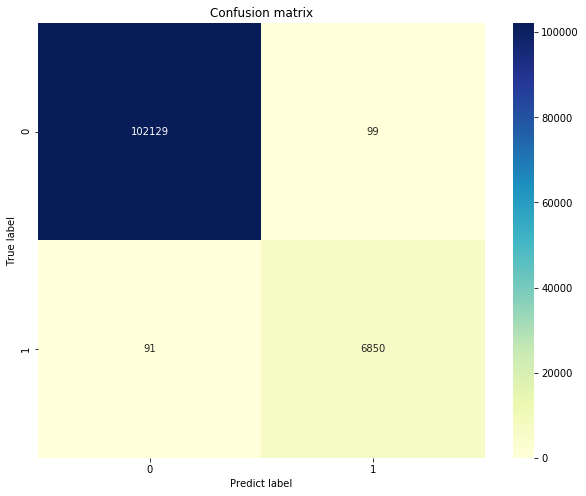

In [29]:
import seaborn as sns
import sklearn.metrics
confusion_matrix = sklearn.metrics.confusion_matrix(validation_label, y_predict)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="YlGnBu")#, annot_kws={"size": 15});
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predict label')
plt.show()